# Credit Risk Prediction

## Importing Packages

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')
palette = sns.color_palette("mako")

## Loading the Data

In [2]:
# loading the data
df = pd.read_excel('ML_challenge_dataset.xlsx')
df.head()

,customer auto id,customer seasonality (frequency of purchase),amount requested,amount issued,unique sale id,paid amount,repayment days,good_bad_flag
0,2198742.0,Weekly,38550.0,38550.0,3322459,38550.0,7.0,NaN
1,3387576.0,Weekly,68900.0,68900.0,3321894,68900.0,6.0,NaN
2,3081652.0,Daily,21800.0,21800.0,3321852,21800.0,6.0,NaN
3,2198724.0,Daily,50000.0,50000.0,3321845,50000.0,6.0,NaN
4,2182883.0,Daily,19480.0,19480.0,3321799,19480.0,4.0,NaN


In [3]:
# getting a summary description of the dataset
print("\033[1m" + 'General summary of the data' + "\033[0m")
display(df.info()) # returns a general summary of the data
print('\n')

print("\033[1m" + 'Numeric description of the data' + "\033[0m")
display(df.describe()) # returns a numeric description of the data
print('\n')

print("\033[1m" + 'Sum of missing values' + "\033[0m")
print(df.isna().sum()) # returns count of missing values in columns

General summary of the data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370 entries, 0 to 3369
Data columns (total 8 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   customer auto id                              2996 non-null   float64
 1   customer seasonality (frequency of purchase)  2996 non-null   object 
 2   amount requested                              3365 non-null   float64
 3   amount issued                                 2777 non-null   float64
 4   unique sale id                                2760 non-null   object 
 5   paid amount                                   2698 non-null   float64
 6   repayment days                                3360 non-null   float64
 7   good_bad_flag                                 0 non-null      float64
dtypes: float64(6), object(2)
memory usage: 210.8+ KB


None



Numeric description of the data


,customer auto id,amount requested,amount issued,paid amount,repayment days,good_bad_flag
count,2.996000e+03,3.365000e+03,2777.000000,2698.000000,3360.000000,0.0
mean,2.863645e+06,4.328743e+04,41614.005041,36170.661601,5.050000,NaN
std,5.935577e+05,7.270687e+04,67595.254317,60902.395235,6.862135,NaN
min,6.801490e+05,5.400000e+02,0.000000,0.000000,0.000000,NaN
25%,2.198845e+06,8.780000e+03,9085.000000,6000.000000,0.000000,NaN
50%,3.087776e+06,2.163000e+04,21100.000000,18000.000000,3.000000,NaN
75%,3.359637e+06,4.872000e+04,46575.000000,41081.250000,7.000000,NaN
max,3.420700e+06,1.033100e+06,780000.000000,780000.000000,55.000000,NaN




Sum of missing values
customer auto id                                 374
customer seasonality (frequency of purchase)     374
amount requested                                   5
amount issued                                    593
unique sale id                                   610
paid amount                                      672
repayment days                                    10
good_bad_flag                                   3370
dtype: int64


In [4]:
# checking unique values
print(df.nunique())
print("\033[1m" + f"There are only {df['customer auto id'].nunique()} unique customer ids in the dataset." + "\033[0m")

customer auto id                                 911
customer seasonality (frequency of purchase)       6
amount requested                                2286
amount issued                                   1947
unique sale id                                  2730
paid amount                                     1744
repayment days                                    45
good_bad_flag                                      0
dtype: int64
There are only 911 unique customer ids in the dataset.


## Data Preprocessing

- The data preprocessing step transforms data into a more useful format that can be used to train an efficient model.

- Before exploratory analysis the missing values in the data need to be handled. I will first drop rows with missing values on the 'amount requested' and 'amount issued' columns as those mean that no loan transactions occured. 
- The 'paid amount' variable is important in determining a customer's willingness and ability to pay. 79 customer records contain missing values both on the 'paid amount' and 'repayment days' columns. Moving forward, I will make the assumption that these loans were not paid and replace nans with 0 in the cells with missing values on both of those columns.
- The dataset also contains duplicate transactions evidenced by duplicates in the unique sale id column and I will drop these.

In [5]:
# renaming the frequency column
df.rename(columns = {'customer seasonality (frequency of purchase)' : 'customer seasonality'},\
    inplace = True)

# dropping records where no loan transactions occurred
df = df.dropna(subset = ['amount requested', 'amount issued'])

# dropping duplicates by the unique sale id column
df.drop_duplicates(subset = 'unique sale id', keep = 'first', inplace = True)

# setting null values to zero
def set_to_zero(df, col1, col2):
    df.loc[df[col1].isnull(), col1] = 0
    df.loc[df[col1] == 0, col2] = 0
    return df

# calling the function
df = set_to_zero(df, 'paid amount', 'repayment days')

df[df['paid amount'].isnull()]

,customer auto id,customer seasonality,amount requested,amount issued,unique sale id,paid amount,repayment days,good_bad_flag


- 3 rows still have missing values in the 'repayment days' columns. These can be imputed using the most appropriate measure of central tendency depending on the distribution of the column data.

The highest repayment days by a customer recorded are 55.0 days.


0.0     597
1.0     238
3.0     214
6.0     198
7.0     196
2.0     188
4.0     174
5.0     174
10.0     89
Name: repayment days, dtype: int64

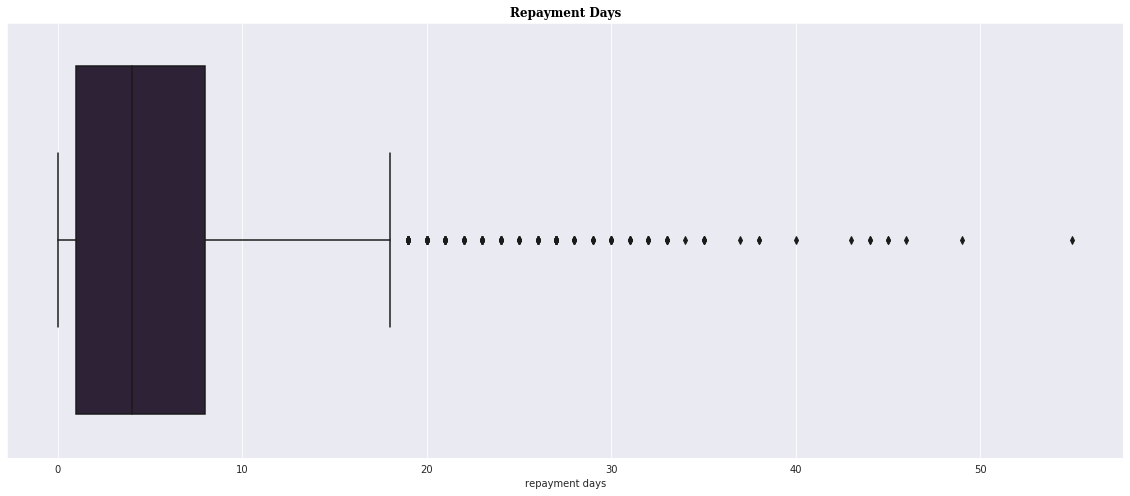

In [6]:
# plotting the distribution of the 'repayment days' column
_ = sns.boxplot(df['repayment days'], palette = palette) 
_.set_title('Repayment Days', fontweight='bold', fontsize=12, color='black', fontfamily='serif')
plt.gcf().set_size_inches(20,8)

# getting the maximum repayment days recorded
print("\033[1m" + f"The highest repayment days by a customer recorded are {df['repayment days'].max()} days." + "\033[0m")

# getting the 10 most common repayment days recorded
display(df['repayment days'].value_counts().sort_values(ascending = False)[:10])

- The maximum repayment days recorded were 55 days while majority of the customers paid back their loans in 1-10 days. This means the data is skewed and therefore Mode will be the imputation technique to use in this case.

In [7]:
# imputing the missing values on the 'repayment days' coluns
df['repayment days'].fillna(df['repayment days'].mode()[0], inplace = True)
df[df['repayment days'].isna()]

,customer auto id,customer seasonality,amount requested,amount issued,unique sale id,paid amount,repayment days,good_bad_flag


- Rows with missing values in the 'customer seasonality' column also have missing values in the 'customer auto id' column which prevents me from comparing with other repeat customer records to derive customer frequency data.

- The best way to fill the missing values is with the most common seasonality among the customers, which is 'Daily'.
- Some of the values in the 'customer seasonality' column are misspelt and need correcting.
- Finally the categorical column 'customer seasonality' will be encoded to have numeric values that the model can train on.

In [8]:
# creating a function to correct misspelt values and replace null values with the 'Daily' frequency
def correct(df, col):
    df.loc[df[col] == 'Quaterly', col] = 'Quarterly'
    df.loc[df[col] == 'Monthy', col] = 'Monthly'
    df.loc[df[col].isnull(), col] = 'Daily'
    return df

# calling the function
correct(df, 'customer seasonality')

# creating mappings for the categorical column
df['customer seasonality'] = df['customer seasonality'].map({
    'Daily': 0,
    'Weekly': 1,
    'Monthly': 2,
    'Quarterly':3
})

## EDA

- Exploratory Data Analysis or as it is commonly referred to, EDA, is important when building machine learning models as it enables you to discover important patterns between variables.

- Before eploring the dataset any further, I will drop some columns that will not be useful in determining customer credit risk.


In [9]:
# making a copy of the dataframe
df_copy = df.copy()

# dropping unnecessary colums
df = df.drop(['unique sale id', 'good_bad_flag'], axis = 1)
df.head()

,customer auto id,customer seasonality,amount requested,amount issued,paid amount,repayment days
0,2198742.0,1,38550.0,38550.0,38550.0,7.0
1,3387576.0,1,68900.0,68900.0,68900.0,6.0
2,3081652.0,0,21800.0,21800.0,21800.0,6.0
3,2198724.0,0,50000.0,50000.0,50000.0,6.0
4,2182883.0,0,19480.0,19480.0,19480.0,4.0


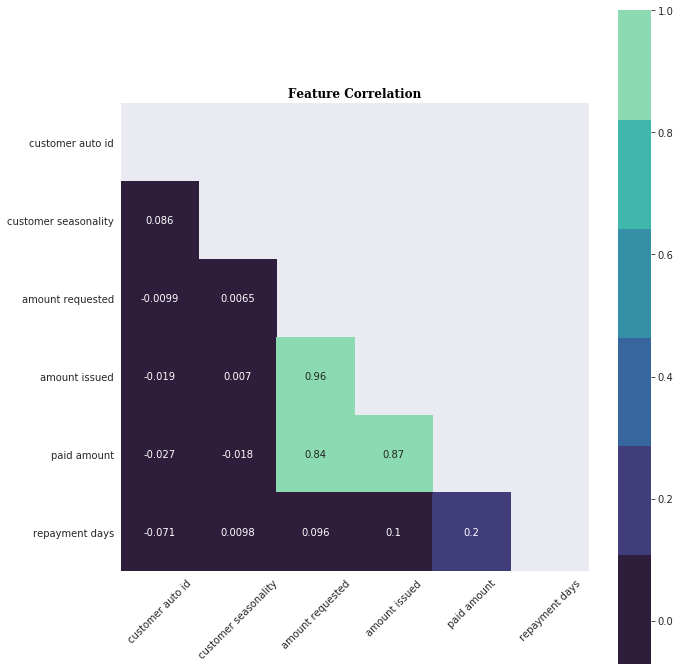

In [10]:
# creating a heatmap to check for collinearity
df_corr = df.corr()
mask = np.triu(df_corr)
_ = sns.heatmap(df_corr, annot = True, square = True, mask = mask, cmap = palette)
_.set_title('Feature Correlation', fontweight='bold', fontsize=12, color='black', fontfamily='serif')
plt.gcf().set_size_inches(10,10)
plt.xticks(rotation = 45)
plt.tight_layout()

- There is a high correlation between 'amount requested', 'amount issued' and 'paid amount' which makes sense as money requested matches money issued and paid except in risk cases.

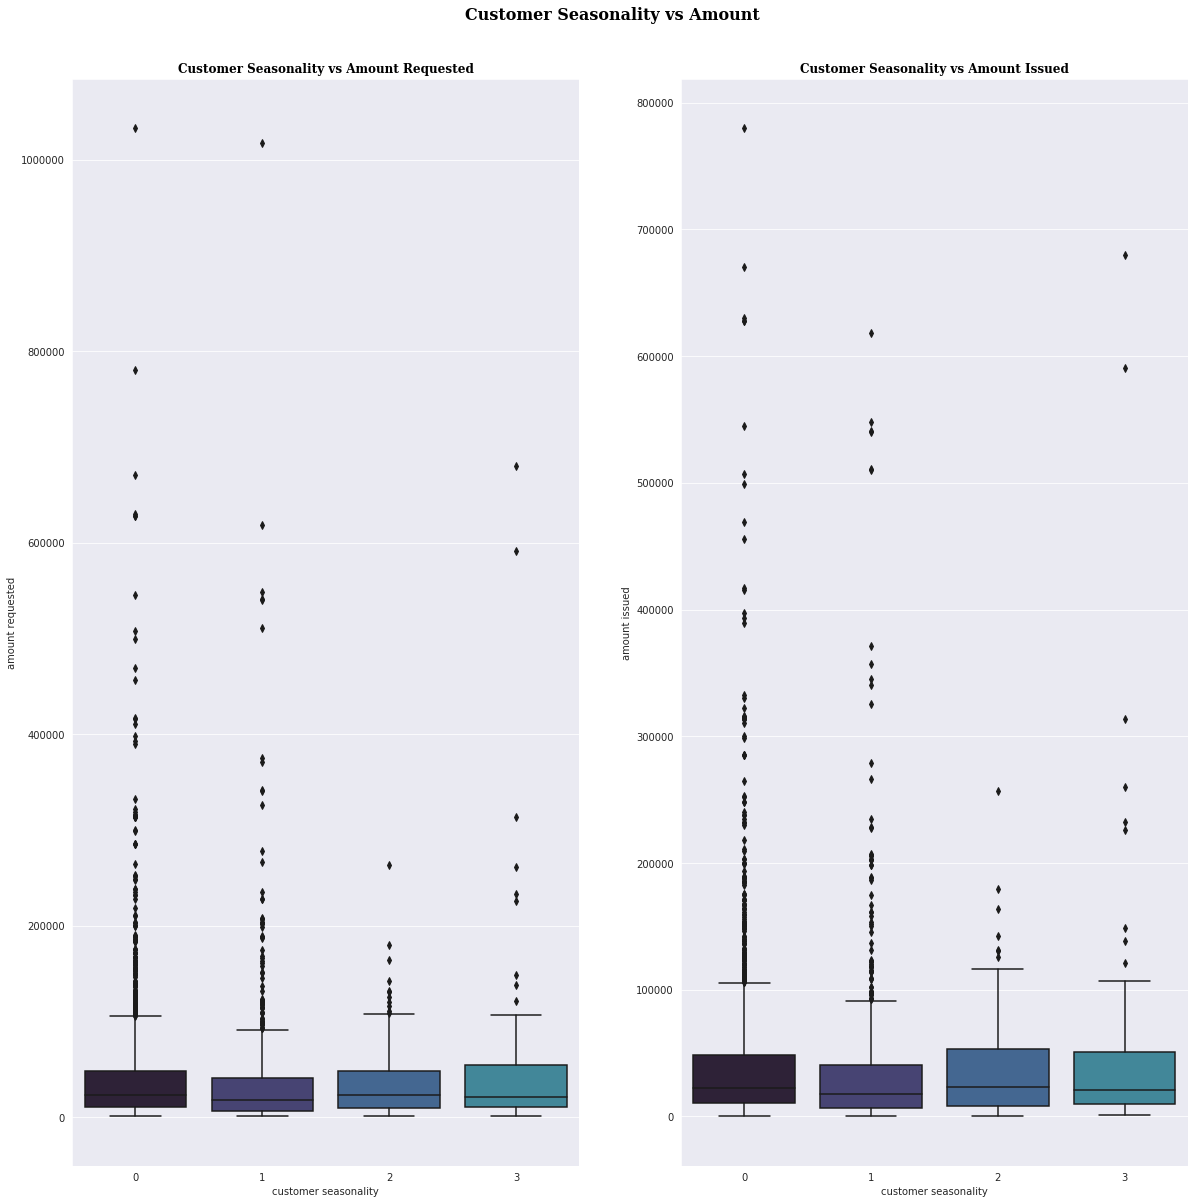

In [11]:
# visualizing the relationship between customer seasonality and the amount requested vs amount issued
fig, (ax1, ax2) = plt.subplots(1,2)
_ = sns.boxplot(x = 'customer seasonality', y = 'amount requested', data = df, palette= palette, ax = ax1)
ax1.set_title('Customer Seasonality vs Amount Requested', fontweight='bold', fontsize=12, color='black', fontfamily='serif')
_ = sns.boxplot(x = 'customer seasonality', y = 'amount issued', data = df, palette= palette, ax = ax2)
ax2.set_title('Customer Seasonality vs Amount Issued', fontweight='bold', fontsize=12, color='black', fontfamily='serif')
fig.suptitle('Customer Seasonality vs Amount', fontweight='bold', fontsize=16, color='black', fontfamily='serif', y=0.93)
plt.gcf().set_size_inches(20,20)


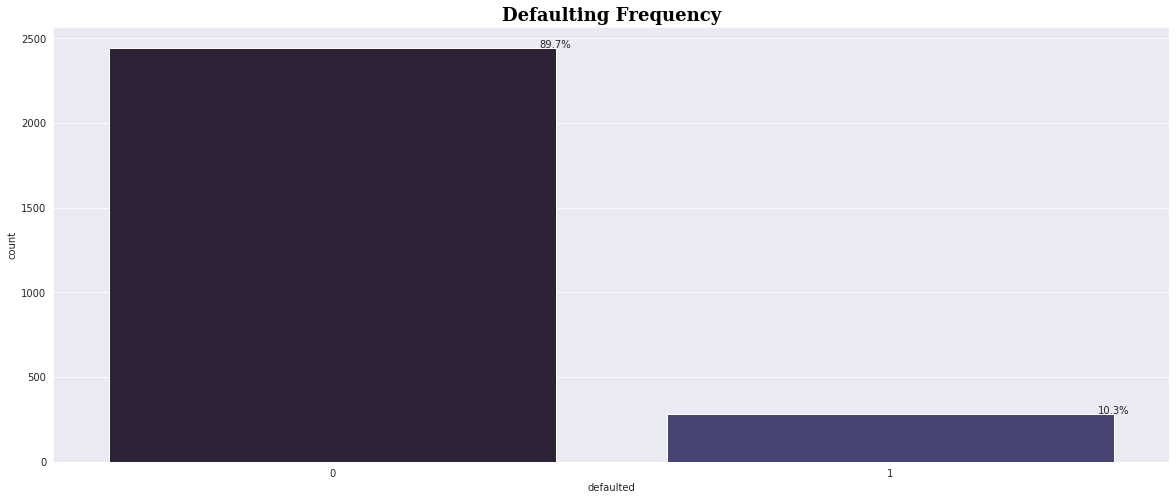

In [12]:
# checking the defaulting frequency
df['defaulted'] = df['paid amount'].apply(lambda x: 0 if x > 1 else 1)

# visualizing the defaulted column
total = float(len(df))
_ = sns.countplot(df['defaulted'], palette= palette)
_.set_title('Defaulting Frequency', fontweight='bold', fontsize=18, color='black', fontfamily='serif')
plt.gcf().set_size_inches(20,8)
for p in _.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    _.annotate(percentage, (x, y),ha='center')
plt.show()

- From the defaulted column, about 10% of the issued loans were not paid back.


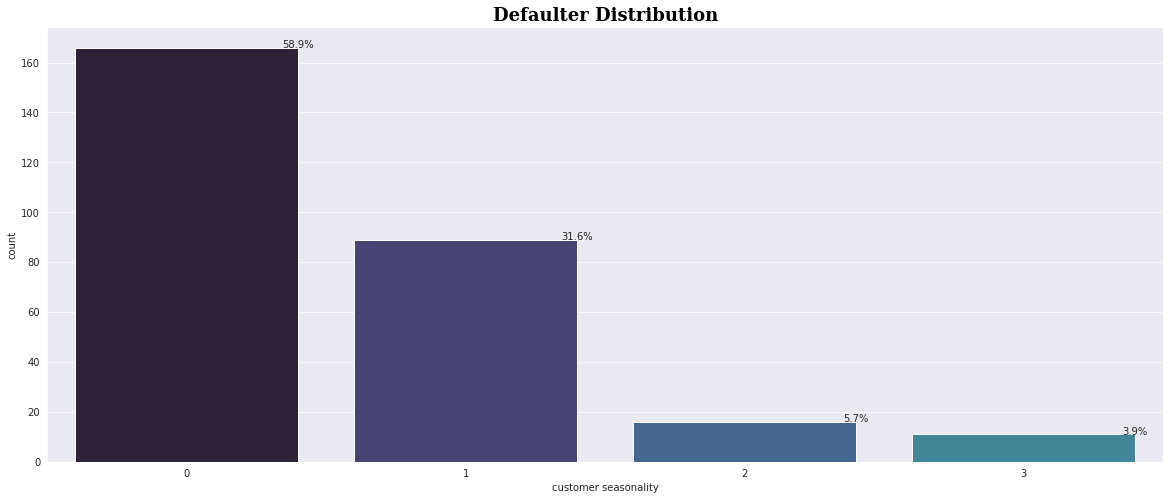

In [13]:
df_new = df[df['defaulted'] == 1]

# visualizing the defaulted column
total = float(len(df_new))
_ = sns.countplot(df_new['customer seasonality'], palette= palette)
_.set_title('Defaulter Distribution', fontweight='bold', fontsize=18, color='black', fontfamily='serif')
plt.gcf().set_size_inches(20,8)
for p in _.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    _.annotate(percentage, (x, y),ha='center')
plt.show()

- An analysis of all the defaulters shows that most defaulter (58.9%) have a daily frequency of purchase. The lowest percentage of defaulters (3.9%) is the group with a quarterly frequency of purchase.

- The current tenure for all loans is 14 days. Now let's analyze the late payments.

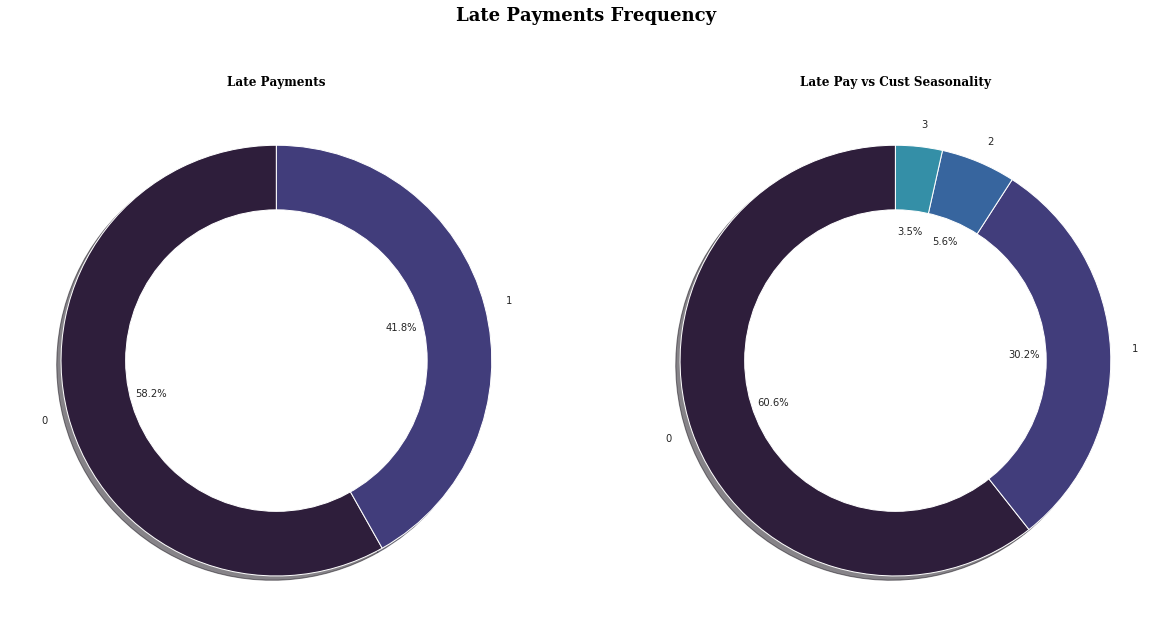

In [14]:
# creating the late payment column a late payment dataframe
df['late payment'] = df['repayment days'].apply(lambda x: 0 if (x <= 14 and x > 1) else 1)
df_late = df[df['late payment'] == 1]

# creating a visualization function
def donut_plot(df, col, title, ax, color = sns.color_palette("mako"), labels = None):
  data = df[col].value_counts()
  if labels is None:
    labels = data.index
  ax.pie(data, colors = color, autopct = '%1.1f%%', shadow = True,
         startangle = 90, labels = labels)
  circle = plt.Circle((0,0), 0.7, color = 'white')
  ax.add_artist(circle)
  ax.set_title(title, fontweight='bold', fontsize=12, color='black', fontfamily='serif')
  plt.tight_layout()

# generating the figure and axes
fig, axs = plt.subplots(1, 2, figsize = (20, 8))
fig.subplots_adjust(hspace = .5, wspace=.1)
fig.suptitle("Late Payments Frequency", fontweight='bold', fontsize=18, color='black', fontfamily='serif', y=1.1)
axs = axs.ravel()
df_list = [df, df_late]

# plotting the data
axs[0] = donut_plot(df, 'late payment', title = 'Late Payments', ax = axs[0])
axs[1] = donut_plot(df_late, 'customer seasonality', title = 'Late Pay vs Cust Seasonality', ax = axs[1])


- About 42% of the loans were paid late. Out of all late pays most loans were issued to customers with a daily frequency of purchase. 
- Some customers repaid less money that what was issued, which I will now analyze.

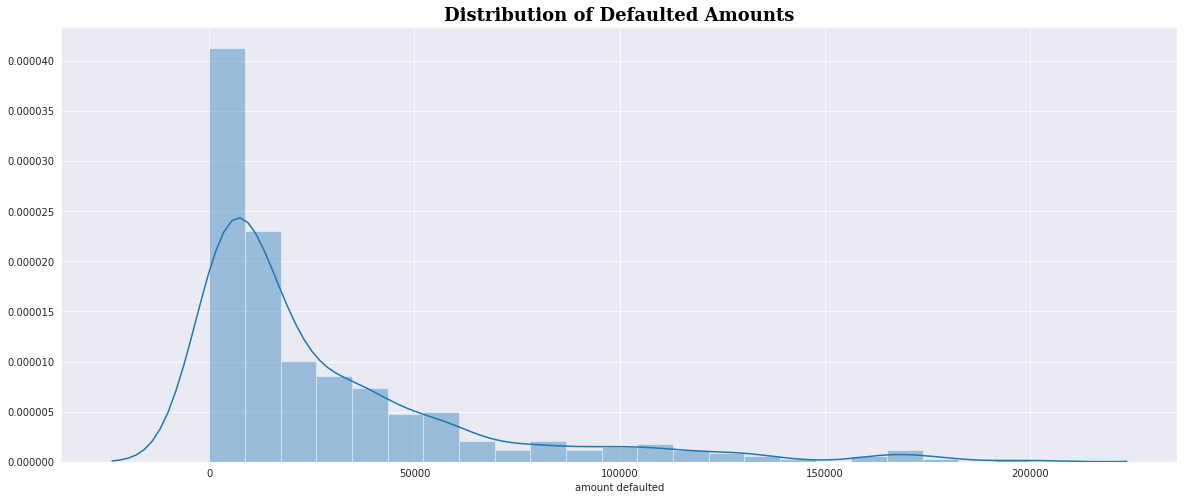

In [15]:
# getting the defaulted amounts
df['amount defaulted'] = df.apply(lambda x: x['amount issued'] - x['paid amount'], axis = 1)

# visualizing the distribution of the defaulted amounts
df_default = df[(df['amount defaulted'] > 0) & (df['amount defaulted'] <200001)] # filtering out outliers
_ = sns.distplot(df_default['amount defaulted'])
_.set_title('Distribution of Defaulted Amounts', fontweight='bold', fontsize=18, color='black', fontfamily='serif')
plt.gcf().set_size_inches(20,8)

- The average defaulted amount is about 6472 with the highest amount being as high as 548000. 

- Some of the loans are requested by new customers, while some are requested by repeat customers. Since this is an important factor as it provides history on a customer's ability and willingness to pay, I will create a column to indicate whether a customer is new or existing depending on whether their customer id is repeated in different transactions in the data.

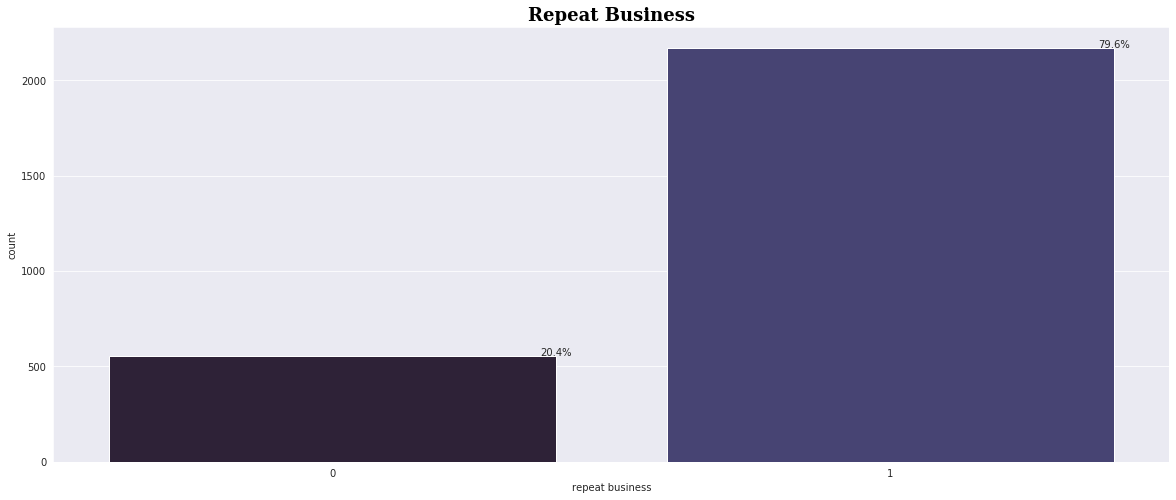

In [16]:
# creating the repeat business column
repeat = df[df['customer auto id'].duplicated()]['customer auto id']
df['repeat business'] = df['customer auto id'].apply(lambda x: 1 if x in repeat.tolist() else 0)
df.head()

#visualizing the customer distribution
total = float(len(df))
_ = sns.countplot(df['repeat business'], palette= palette)
_.set_title('Repeat Business', fontweight='bold', fontsize=18, color='black', fontfamily='serif')
plt.gcf().set_size_inches(20,8)
for p in _.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    _.annotate(percentage, (x, y),ha='center')
plt.show()

- It looks like most of the customers are existing ones who have carried out loan transactions at least more than once.

In [17]:
# dropping the 'customer auto id' column
df.drop('customer auto id', axis = 1, inplace = True)
df.head()

,customer seasonality,amount requested,amount issued,paid amount,repayment days,defaulted,late payment,amount defaulted,repeat business
0,1,38550.0,38550.0,38550.0,7.0,0,0,0.0,1
1,1,68900.0,68900.0,68900.0,6.0,0,0,0.0,1
2,0,21800.0,21800.0,21800.0,6.0,0,0,0.0,0
3,0,50000.0,50000.0,50000.0,6.0,0,0,0.0,1
4,0,19480.0,19480.0,19480.0,4.0,0,0,0.0,1


## Modeling the Data

- As this is an unsupervised learning problem (no labels), I will use clustering algorithms to find structure in the data and group similar records together to predict if a loan was good or bad.

- I will reduce the dimensionality of the data using PCA to highlight the most significant features in the data and minimize information loss.

- PCA is highly sensitive to scale. The variables have varying scales and therefore I need to standardize the features before PCA transformation. 

Main components: (2728, 6)
Variance % covered by main component: 33


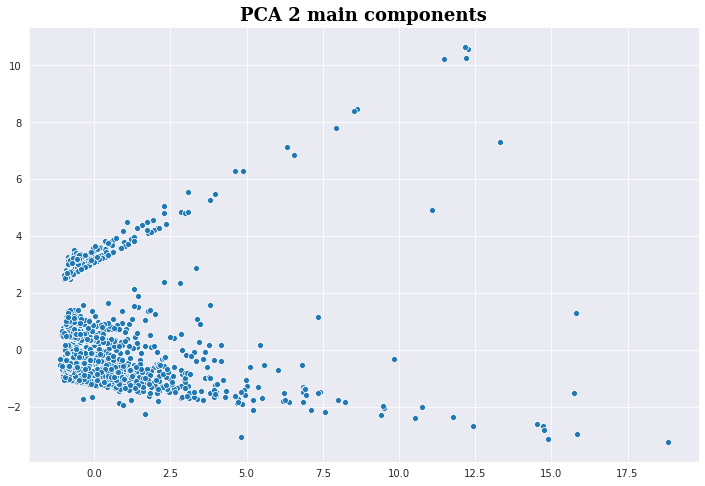

In [18]:
# scaling the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

# dimensionality reduction
pca = PCA(n_components = 0.9, random_state = 101)
pca_df = pca.fit_transform(scaled_df)

print(f'Main components: {pca_df.shape}')
print(f'Variance % covered by main component: {round(pca.explained_variance_ratio_[0] * 100)}')

# visualizing the data on the first two main components
_ = sns.scatterplot(pca_df[:,0], pca_df[:,1], palette = palette)
_.set_title('PCA 2 main components', fontweight='bold', fontsize=18, color='black', fontfamily='serif')
plt.gcf().set_size_inches(12,8)

In [19]:
pca_df[:,1]

array([-0.73952612, -0.81990316, -0.24943182, ..., -0.86986509,
       -0.23789034,  7.78284162])

- Now that the data is scaled and PCA transformed, I will first run the data clustering using the KMeans specifying two clusters and then visualize again to see the distribution of the clusters.

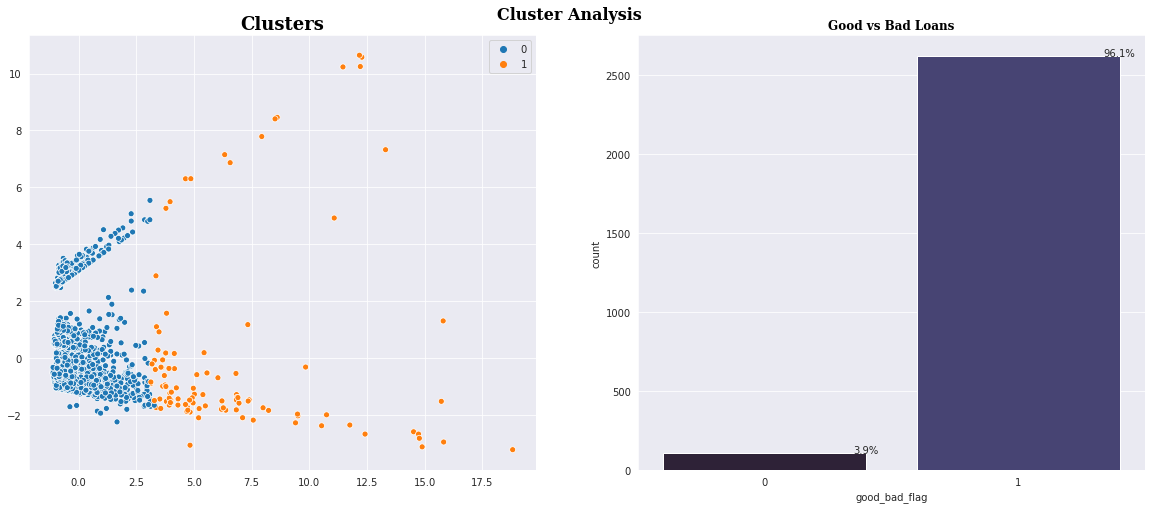

In [20]:
# fitting the model
kmeans = KMeans(n_clusters = 2, random_state = 101)
df['good_bad_flag'] = kmeans.fit_predict(pca_df)
cluster_labels = kmeans.labels_
centers = kmeans.cluster_centers_

# # inverting the clusters
df['good_bad_flag'] = df['good_bad_flag'].apply(lambda x: 0 if x == 1 else 1)

# plotting using the cluster labels and counts
fig, (ax1, ax2) = plt.subplots(1,2)
_ = sns.scatterplot(pca_df[:,0], pca_df[:,1], hue = cluster_labels, ax = ax1)
ax1.set_title('Clusters', fontweight='bold', fontsize=18, color='black', fontfamily='serif')
_ = sns.countplot(df['good_bad_flag'], palette= palette, ax = ax2)
ax2.set_title('Good vs Bad Loans', fontweight='bold', fontsize=12, color='black', fontfamily='serif')
fig.suptitle('Cluster Analysis', fontweight='bold', fontsize=16, color='black', fontfamily='serif', y=0.93)
total = float(len(df))
for p in _.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    _.annotate(percentage, (x, y),ha='center')
plt.gcf().set_size_inches(20,8)
plt.show()

In [21]:
# Analysing customer behavior based on clusters
display(df[['amount requested', 'amount issued', 'repayment days', 'amount defaulted']].describe())
df.groupby('good_bad_flag').agg({'customer seasonality': pd.Series.mode,
                                 'amount requested': 'mean',
                                 'amount issued': 'mean',
                                 'repayment days': 'median',
                                 'defaulted': 'mean',
                                 'late payment': 'mean',
                                 'repeat business': 'mean'}).reset_index()

,amount requested,amount issued,repayment days,amount defaulted
count,2.728000e+03,2728.000000,2728.000000,2728.000000
mean,4.206555e+04,41283.922654,6.165689,6116.763563
std,7.197243e+04,67235.456198,7.126885,33375.506404
min,6.600000e+02,0.000000,0.000000,0.000000
25%,9.135000e+03,9022.500000,1.000000,0.000000
50%,2.112250e+04,21000.000000,4.000000,0.000000
75%,4.649250e+04,46252.500000,8.000000,0.000000
max,1.033100e+06,780000.000000,55.000000,548000.000000


,good_bad_flag,customer seasonality,amount requested,amount issued,repayment days,defaulted,late payment,repeat business
0,0,0,314523.411215,301384.345794,5.0,0.121495,0.504673,0.607477
1,1,0,30942.704311,30665.553605,4.0,0.102633,0.414727,0.803892


## Cluster Patterns

- The goal was to oredict if a loan was good or bad where Good is 1 and Bad is 0

**Cluster 1**
- The customer records falling in cluster 1 (good loans) are characterized by low loan amounts requested with corresponding low amounts issued. The median repayment days for good loans is 4 days. 41% of the loans were paid late and about 10% were defaulted. About 80% of the good loans were requested and issued to repeat customers.

**Cluster 2**
- The customer records falling in cluster 0 (bad loans) are characterized by large loan amounts requested (with an average of about 314523 compared to 30665 for good loans) with corresponding low amounts issued. The median repayment days for bad loans is 5 days. 50% of the bad loans were paid late and about 12% were defaulted.About 60% of the bad loans were requested and issued to repeat customers.

- There is a clear relationship between loans of large amounts and bad loans.


In [22]:
# merging ids to final dataframe
customer_auto_id = df_copy['customer auto id']
unique_sale_id = df_copy['unique sale id']

df.insert(0, 'customer auto id', customer_auto_id, True)
df.insert(4, 'unique sale id', unique_sale_id, True)

df.head()

,customer auto id,customer seasonality,amount requested,amount issued,unique sale id,paid amount,repayment days,defaulted,late payment,amount defaulted,repeat business,good_bad_flag
0,2198742.0,1,38550.0,38550.0,3322459,38550.0,7.0,0,0,0.0,1,1
1,3387576.0,1,68900.0,68900.0,3321894,68900.0,6.0,0,0,0.0,1,1
2,3081652.0,0,21800.0,21800.0,3321852,21800.0,6.0,0,0,0.0,0,1
3,2198724.0,0,50000.0,50000.0,3321845,50000.0,6.0,0,0,0.0,1,1
4,2182883.0,0,19480.0,19480.0,3321799,19480.0,4.0,0,0,0.0,1,1


In [23]:
df.to_csv('credit_risk_prediction.csv', index = False)